# Group Work Project - Computational Finance - Submission 1
# Price a European Up-and-out Call Option

In [1]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Market information
risk_free = 0.08

# Share specific information
S_0 = 100
sigma = 0.3

# Option specific information
strike = 100
T = 1
barrier = 150

# Firm specific information
V_0 = 200
sigma_firm = 0.25
debt = 175
recovery_rate = 0.25

# Correlation between the counterparty and the stock
correlation = 0.2

## 4 - Price a European call option

In [3]:
# Code for analytic solution for vanilla European call option
def vanilla_euro_call(S_0, K, r, sigma, T):

    '''Analytical solution for vanilla European call option        
    
    Parameters
    ----------------   
    S_0: float
        Initial share price
    
    K: float
        Option strike price
   
    r: float
        risk free interest rate
    
    sigma: float
        Stock volatility
    
    T: float
        Time to maturity (in years)       
    '''
    d_1 = (np.log(S_0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)

    return S_0*norm.cdf(d_1)-K*np.exp(-r*T)*norm.cdf(d_2)


analytic_call_price = vanilla_euro_call(S_0, strike, risk_free, sigma, T)

print(f'Price for vanilla European call option = ${analytic_call_price:.2f}')

Price for vanilla European call option = $15.71


## 5 - Price a European up-and-out barrier call option (Monte Carlo)

In [4]:
#Helper functions for valuation
def share_path(S_0, r, sigma, Z, dT):
    '''Generates a share path under BSM model 
        
        Parameters
    ----------------   
    S_0: float
        Initial share price
   
    r: float
        risk free interest rate
    
    sigma: float
        Stock volatility
    
    Z: float
        Random draw from a standard normal distribution
    
    dT: float
        Time step
    '''
    path = S_0*np.exp(np.cumsum((r-sigma**2/2)*dT+sigma*np.sqrt(dT)*Z, axis=1))
    return np.insert(path, [0], S_0, axis=1)

def discounted_call_payoff(S_T, K, r, T):
    '''Evaluate the discounted call payoff 
        
        Parameters
    ----------------   
    S_T: float
        Terminal share price
   
    K: float
        Option strike price
    
    r: float
        risk free interest rate
    
    T: float
        Time to maturity (in years)
    
    '''   
    return np.exp(-r*T)*np.maximum(S_T-K, 0)


def up_and_out_call_option(S_0, K, B, r, sigma, T, n_sim):
    '''
    Pricing of up-and-out call options under BSM model using Monte Carlo
    Returns: Call value and standard error of an up-and-out barrier option with European call

    Parameters
    ----------------
    S_0: float
        Initial stock price
        
    K: float
        Strike or exercise price
        
    B: float
        Barrier level
    
    r: float
        Risk free interest rate
        
    sigma: float
        Stock volatility
    
    T: float
        Time to maturity (in years)
    
    n_sim: integer
        Sample size to be simulated
    '''
    
    # step size in years
    dt = T / 12
       
    # Generate share paths and calculate call prices
    Z = norm.rvs(size = (n_sim, 12))
    stock_prices = share_path(S_0, r, sigma, Z, dt)
    terminal_values = stock_prices[:,-1]
    call_prices = discounted_call_payoff(terminal_values, K, r, T)*(stock_prices.max(axis=1) < B)

    # Monte Carlo estimate and standard error
    mccall_estimate = np.mean(call_prices)
    mccall_se = np.std(call_prices)/np.sqrt(n_sim)

    return mccall_estimate, mccall_se

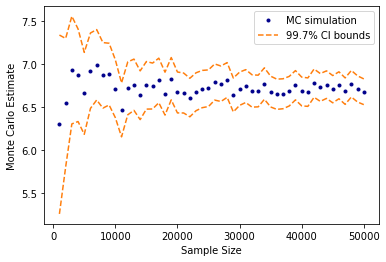

In [5]:
# Simulate European up-and-out barrier for different sample sizes

# Set random seed for reproducibility
np.random.seed(17)

# Sample sizes to be simulated
sample_sizes = range(1000, 51000, 1000)

# Pre-allocate space to store estimates
mccall_estimates = np.zeros(len(sample_sizes))
mccall_se = np.zeros(len(sample_sizes))

# Loop through sample sizes and calculate MC estimates
for n in sample_sizes:
    call = up_and_out_call_option(S_0, strike, barrier, risk_free, sigma, T, n)
    mccall_estimates[n//1000-1] = call[0]
    mccall_se[n//1000-1] = call[1]

# Plotting the graph
plt.plot(sample_sizes, mccall_estimates, '.', label = 'MC simulation', color='darkblue')
plt.plot(sample_sizes, mccall_estimates-3*mccall_se, '--', color='C1', label = '99.7% CI bounds')
plt.plot(sample_sizes, mccall_estimates+3*mccall_se, '--', color='C1')
plt.xlabel('Sample Size')
plt.ylabel('Monte Carlo Estimate')
plt.legend()
plt.show()

## 6 - Price a European up-and-in barrier call option

In [6]:
def up_and_in_call_option(S_0, K, B, r, sigma, T, n_sim):
    '''
    Pricing of up and in call options under BSM model using Monte Carlo
    Returns: Call value and standard error of an up-and-in barrier option with European call

    Parameters
    ----------------
    S_0: float
        Initial stock price
        
    K: float
        Strike or exercise price
        
    B: float
        Barrier level
        
    r: float
        Risk free interest rate
        
    sigma: float
        Stock volatility
    
    T: float
        Time to maturity (in years)
    
    n_sim: integer
        Sample size to be simulated
    '''
    vanilla_call = vanilla_euro_call(S_0, K, r, sigma, T)
    upandout_call = up_and_out_call_option(S_0, K, B, r, sigma, T, n_sim)

    return vanilla_call - upandout_call[0], upandout_call[1]

In [7]:
# Set random seed for reproducibility
np.random.seed(17)

upandin_call = up_and_in_call_option(S_0, strike, barrier, risk_free, sigma, T, 100000)
print(f'Price for European up-and-in barrier call option = ${upandin_call[0]:.2f}')

Price for European up-and-in barrier call option = $8.96


## 7 - Price up-and-out barrier call option as a function of strike price

In [8]:
prices = [up_and_out_call_option(S_0, k, barrier, risk_free, sigma, T, 100000)[0] for k in range(85, 120, 5)]

import pandas as pd
pd.DataFrame({'strike': range(85, 120, 5), 'option price':[format(i, '.2f') for i in prices]})

,strike,option price
0,85,13.52
1,90,10.88
2,95,8.72
3,100,6.71
4,105,5.06
5,110,3.66
6,115,2.58


## 8 - Monte Carlo estimates of default-free value of the option and CVA

In [9]:
# Set random seed for reproducibility
np.random.seed(17)

# Helper functions for valuations
def terminal_value(S_0, r, sigma, Z, T):
    '''Generates the terminal stock price under BSM model'''
    return S_0*np.exp((r-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def up_and_out_call_payoff (path, K, B):
    '''Evaluates the payoff of the European up-and-out barrier call option'''
    return np.maximum(path[:,-1]-K, 0) if path.max(axis=1) < B else 0

n_sim = 100000

dT = T/12

correl_matrix = np.array([[1, correlation],[correlation, 1]])

amount_lost = np.zeros(n_sim)
option_price = np.zeros(n_sim)

for i in range(n_sim):
    norm_matrix = norm.rvs(size=(2, 12))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(correl_matrix), norm_matrix)

    stock_path = share_path(S_0, risk_free, sigma, corr_norm_matrix[0].reshape(1,-1), dT)
    option_val = up_and_out_call_payoff(stock_path, strike, barrier)
    
    firm_path = share_path(S_0, risk_free, sigma_firm, corr_norm_matrix[1].reshape(1,-1), dT)
    term_firm_val = firm_path[:, -1]

    amount_lost[i] = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val<debt)*option_val
    option_price[i] = np.exp(-risk_free*T)*option_val
    
cva_estimate = np.mean(amount_lost)
cva_se = np.std(amount_lost)/np.sqrt(n_sim)

call_estimate = option_price.mean()
call_se = option_price.std()/np.sqrt(n_sim) 

# Code to calculate probability of default
d_1 = (np.log(V_0/debt) + (risk_free+sigma_firm**2/2))/(sigma_firm*np.sqrt(T))
d_2 = d_1 - sigma_firm*np.sqrt(T)
default_prob = norm.cdf(-d_2)

# zero correlation CVA
uncorr_cva = (1-recovery_rate)*default_prob*call_estimate

print(f'Default free value of the option = {call_estimate:.2f}')
print(f'99.7% CI bounds default free = [{call_estimate-3*call_se:.2f}, {call_estimate+3*call_se:.2f}]')
print()
print(f'CVA estimate = {cva_estimate:.2f}')
print(f'99.7% CI bounds CVA = [{cva_estimate-3*cva_se:.2f}, {cva_estimate+3*cva_se:.2f}]')
print(f'Probability of default = {default_prob:g}')
print(f'Uncorrelated CVA = {uncorr_cva:.2f}')

Default free value of the option = 6.75
99.7% CI bounds default free = [6.64, 6.86]

CVA estimate = 4.94
99.7% CI bounds CVA = [4.86, 5.02]
Probability of default = 0.232962
Uncorrelated CVA = 1.18


## 9 - Monte Carlo estimates for the price of the option incorporating counterparty risk

In [13]:
option_price_risk = np.zeros(n_sim)

for i in range(n_sim):
    norm_matrix = norm.rvs(size=(2, 12))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(correl_matrix), norm_matrix)

    stock_path = share_path(S_0, risk_free, sigma, corr_norm_matrix[0].reshape(1,-1), dT)
    option_val = up_and_out_call_payoff(stock_path, strike, barrier)
    
    firm_path = share_path(S_0, risk_free, sigma_firm, corr_norm_matrix[1].reshape(1,-1), dT)
    term_firm_val = firm_path[:, -1]

    cva = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val<debt)*option_val
    option_price_risk[i] = np.exp(-risk_free*T)*option_val - cva 


call_estimate_risk = option_price_risk.mean()
call_se_risk = option_price_risk.std()/np.sqrt(n_sim) 

print(f'Value of the option with counterparty risk = {call_estimate_risk:.2f}')
print(f'99.7% CI bounds counterparty risk = [{call_estimate_risk-3*call_se_risk:.2f}, {call_estimate_risk+3*call_se_risk:.2f}]')

Value of the option with counterparty risk = 1.80
99.7% CI bounds counterparty risk = [1.77, 1.84]
